In [57]:
from torch import nn, load as torch_load
import torch
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import model as efficientnet_model
from tqdm import tqdm
from skimage import io as skio, color
import os
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score

In [50]:
output_dimensions = 5
data_dir = '../dataset'
images_dir = os.path.join(data_dir, 'tiles')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [36]:
df_test = pd.read_csv(f'{data_dir}/split/test.csv')

In [18]:
class EfficientNet(nn.Module):
    """
        Classe que implementa a arquitetura EfficientNet

        Parâmetros:
            backbone: str
                Nome do modelo de EfficientNet a ser utilizado
            output_dimensions: int
                Número de neuronios na camada de saída
    """
    def __init__(self, output_dimensions):
        super().__init__()
        self.efficient_net = efficientnet_model.EfficientNet.from_pretrained("efficientnet-b0")
        self.efficient_net.load_state_dict(
            torch_load("pre-trained-models/efficientnet-b0-08094119.pth", weights_only=True)
        )
        self.fully_connected = nn.Linear(self.efficient_net._fc.in_features, output_dimensions)
        self.efficient_net._fc = nn.Identity()

    def extract(self, inputs):
        return self.efficient_net(inputs)

    def forward(self, inputs):
        x = self.extract(inputs)
        x = self.fully_connected(x)

        return x

In [28]:
class PandasDataset(Dataset):
    def __init__(self, root_dir, dataframe, transforms=None):
        self.root_dir = root_dir 
        self.dataframe = dataframe
        self.transforms = transforms

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_id = row.image_id.strip()
        
        file_path = os.path.join(self.root_dir, f'{img_id}.jpg')
        tile_image = skio.imread(file_path)
        
        if self.transforms is not None:
            tile_image = self.transforms(image=tile_image)['image'] 

        tile_image = tile_image.astype(np.float32) / 255.0 
        tile_image = np.transpose(tile_image, (2, 0, 1))

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        
        return torch.tensor(tile_image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [51]:
model = EfficientNet(output_dimensions)
model.load_state_dict(
    torch_load(
        "pre-trained-models/efficientnet-b0_segmented_fold_0.pth", 
        weights_only=True,
        map_location=device
    )
)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [52]:
def calculate_metrics(preds, targets, df):
    accuracy = (preds == targets).mean() * 100. # Calcula a acurácia em porcentagem
    quadraditic_weighted_kappa = cohen_kappa_score(preds, targets, weights='quadratic') # Calcula o kappa quadrático ponderado dos dados em geral

    quadraditic_weighted_kappa_karolinska = cohen_kappa_score(preds[df['data_provider'] == 'karolinska'], df[df['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    quadraditic_weighted_kappa_radboud = cohen_kappa_score(preds[df['data_provider'] == 'radboud'], df[df['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')

    return accuracy, quadraditic_weighted_kappa, quadraditic_weighted_kappa_karolinska, quadraditic_weighted_kappa_radboud

def evaluation(model, dataloader):
    model.eval()
    model.to(device)

    bar_progress = tqdm(dataloader)

    all_logits = []
    preds = []
    targets = []

    with torch.no_grad():
        for index, (batch_data, batch_targets) in enumerate(bar_progress):           
            batch_data, batch_targets = batch_data.to(device), batch_targets.to(device)

            logits = model(batch_data)
            

            prediction = logits.sigmoid()
            prediction = prediction.sum(1).detach().round()
        
            all_logits.append(logits)
            preds.append(prediction)
            targets.append(batch_targets.sum(1))           

        
    all_logits = torch.cat(all_logits).cpu().numpy()
    preds = torch.cat(preds).cpu().numpy()
    targets = torch.cat(targets).cpu().numpy()

    accuracy, quadraditic_weighted_kappa, quadraditic_weighted_kappa_karolinska, quadraditic_weighted_kappa_radboud = calculate_metrics(preds, targets, df_test)

    return {
        "val_acc":accuracy, 
        "quadraditic_weighted_kappa":quadraditic_weighted_kappa, 
        "quadraditic_weighted_kappa_karolinska":quadraditic_weighted_kappa_karolinska, 
        "quadraditic_weighted_kappa_radboud":quadraditic_weighted_kappa_radboud
    }  

In [54]:
dataset_test = PandasDataset(images_dir, df_test, transforms = None)
dataloader_test = DataLoader(dataset_test, batch_size=10, shuffle=False)
evaluation(model, dataloader_test)

 36%|███▋      | 58/160 [23:37<41:32, 24.43s/it]  


KeyboardInterrupt: 

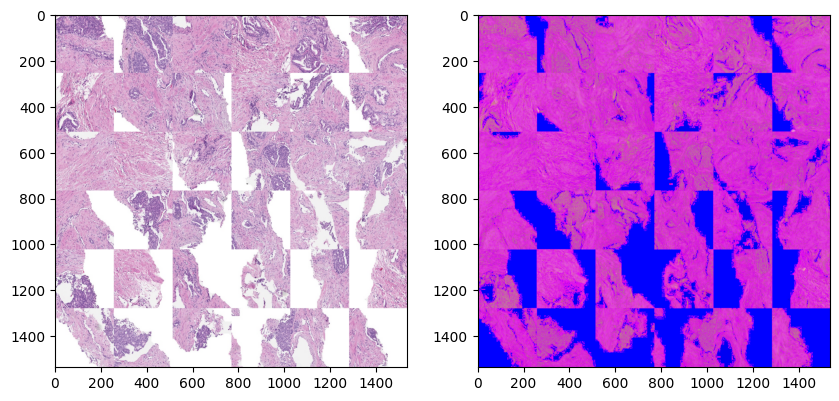

In [59]:
image = skio.imread('../dataset/tiles/0a6e7a0cfe6a3203b4cb28d6ff6daa6a.jpg')
image_hsv = color.rgb2hsv(image)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(image_hsv)
plt.show()